In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold, train_test_split, StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_wine
import optuna

/home/dom/python_global_venvs/ML/venv/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
X, Y = load_wine(return_X_y=True)
X.shape, Y.shape

((178, 13), (178,))

(array([59.,  0.,  0.,  0.,  0., 71.,  0.,  0.,  0., 48.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

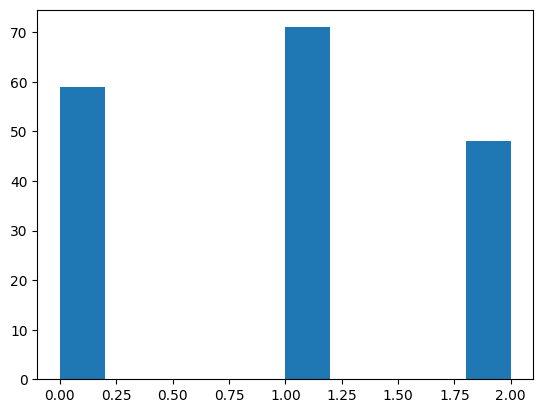

In [3]:
plt.hist(Y)

In [22]:
class_counts = [np.sum(Y == k) for k in [0, 1, 2]]
class_ratios = [cc / sum(class_counts) for cc in class_counts]

class_counts, class_ratios

([59, 71, 48], [0.33146067415730335, 0.398876404494382, 0.2696629213483146])

In [4]:
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#
# for i, (train, test) in enumerate(skf.split(X, Y)):
#     print(f"Fold {i}:")
#     X_train, X_test = X[train], X[test]
#     y_train, y_test = Y[train], Y[test]

In [10]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train, test = next(sss.split(X, Y))
Xtr, Xte = X[train], X[test]
Ytr, Yte = Y[train], Y[test]
train.shape, test.shape

((124,), (54,))

lr_accuracy=0.98


/home/dom/python_global_venvs/ML/venv/lib64/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


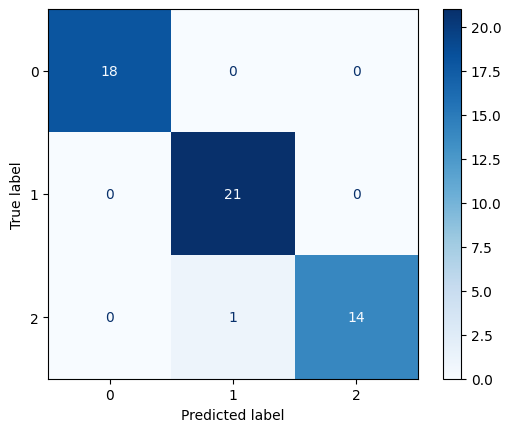

In [28]:
lr_model = LogisticRegression()
# sample_weights = np.array([1 / class_ratios[k] for k in Ytr])
lr_model.fit(Xtr, Ytr)

pred = lr_model.predict(Xte)
lr_accuracy = accuracy_score(Yte, pred)
print(f"{lr_accuracy=:.2f}")

cm = confusion_matrix(Yte, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

knn_accuracy=0.72


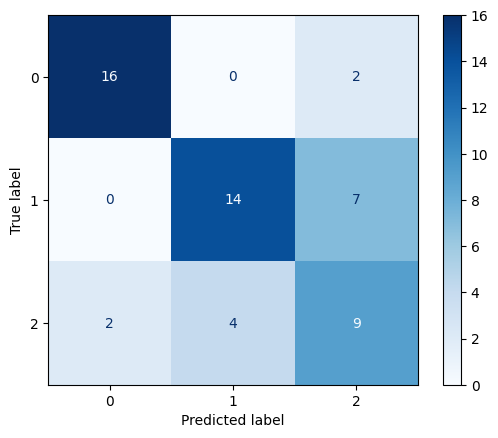

In [12]:
knn = KNeighborsClassifier()
knn.fit(Xtr, Ytr)

pred = knn.predict(Xte)
knn_accuracy = accuracy_score(Yte, pred)
print(f"{knn_accuracy=:.2f}")

cm = confusion_matrix(Yte, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

lda_accuracy=0.98


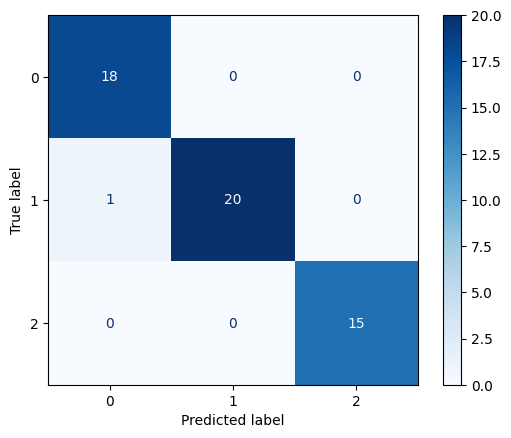

In [13]:
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(Xtr, Ytr)

pred = lda_model.predict(Xte)
lda_accuracy = accuracy_score(Yte, pred)
print(f"{lda_accuracy=:.2f}")

cm = confusion_matrix(Yte, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

In [ ]:
def objective_C():